In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
assert pyro.__version__.startswith('1.6.0')

import torch
import torch.distributions as td

import numpy as np
from tqdm.auto import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import arviz

from collections import OrderedDict, namedtuple
from pyro import poutine

import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
from torch.distributions import constraints

import torch.distributions  as td

import pyro.distributions as pd
from pyro.optim import ClippedAdam
from pyro.infer import Predictive, SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.infer import config_enumerate, infer_discrete
from pyro import poutine

from tabulate import tabulate
from collections import namedtuple, OrderedDict
import random

In [3]:
random.seed(0)
np.random.seed(0)
pyro.set_rng_seed(0)
torch.manual_seed(0)
rng = np.random.RandomState(0)

In [4]:
import pickle
import numpy as np

Create some predictors

In [5]:
# G, N, 3
N = 1000
inputs = np.stack(
    [
        rng.poisson(2., size=N),
        rng.poisson(2., size=N),
        rng.poisson(7., size=N),
        np.where(rng.normal(0., 1., size=N) > 0., rng.poisson(10., size=N), rng.poisson(20., size=N))
    ],
    1
)
w1 = rng.normal(0., 0.5)
b1 = rng.normal(0., 1.)
inputs = np.stack([inputs, inputs * w1 + b1], -1)
inputs.shape

(1000, 4, 2)

In [6]:
w2 = rng.normal(0., 1.0)
b2 = rng.normal(0., 2.0)
outputs = rng.poisson(1 + np.abs(np.where(rng.normal(0., 1.0, size=inputs.shape[:-1]) > -1, inputs[...,0] * w2 + b2, inputs[...,1] * w2 * 2 + b2 * 2)))
outputs.shape

(1000, 4)

In [7]:
group_names = ('P2', 'P2', 'P7', 'P10P20')

In [8]:
from probabll.bda.glm import Plotting

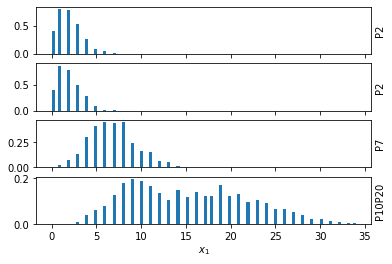

In [9]:
_ = Plotting.obs(inputs[...,0], xlabels=r'$x_1$', ylabels=group_names, bins=100)

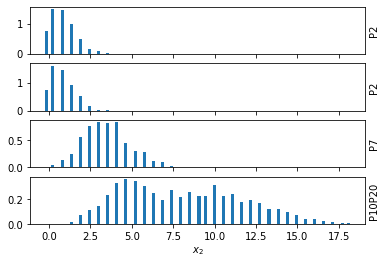

In [10]:
_ = Plotting.obs(inputs[...,1], xlabels=r'$x_2$', ylabels=group_names, bins=100)

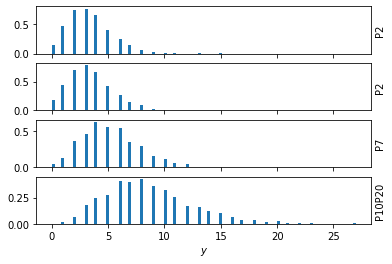

In [11]:
_ = Plotting.obs(outputs, xlabels=r'$y$', ylabels=group_names, bins=100)

# Hierarchical Poisson Regression

* Count data $y_n$
* $I$-dimensional input predictors $\mathbf x_n$

\begin{align}
    \mu &\sim \mathcal N(0, 100) \\
    \mathbf s &\sim \mathcal N(\mathbf 0_I, 100 \times \mathbf 1_I) \\
    \text{For each group }g=1, \ldots, G& \\
    \mathbf w_g &\sim \mathcal N(\mathbf 0_I, \mathbf 1_I)\\
    b_g &\sim \mathcal N(0,1) \\
    \text{For each observation }n=1, \ldots, N &\\
    y_{n,g}|\mathbf x_{n,g} &\sim \mathrm{Poisson(\lambda_{n,g})}\\
    \lambda_{n,g} &= \mathrm{softplus}(\mu + (\mathbf s + \mathbf w_g)^\top \mathbf x_n + b_g) 
\end{align}

Alternatively, we can also use a GammaPoisson (a reparematerisation of the NegativeBinomial) likelihood:

\begin{align}
    \text{For each group }g=1, \ldots, G& \\
    \beta_g &\sim \mathrm{Exp}(1) \\
    \text{For each observation }n=1, \ldots, N &\\
    y_{n,g}|\mathbf x_{n,g} &\sim \mathrm{GammaPoisson(\lambda_{n,g}, \beta_g)}\\
    \lambda_{n,g} &= \mathrm{softplus}(\mu + (\mathbf s + \mathbf w_g)^\top \mathbf x_n + b_g) 
\end{align}

Note that $\mathrm{GammaPoisson}(\lambda, 1) \sim \mathrm{Poisson}(\lambda)$.

In [12]:
from probabll.bda.glm import Family, GeneralisedLinearModelR1

In [13]:
model = GeneralisedLinearModelR1(
    #Family.Poisson(),
    Family.GammaPoisson(2., 2.), # You can support new families if needed
    mu_scale=10., 
    s_scale=1.,
    w_scale=1.,
    b_scale=1.,
    device=torch.device('cuda:0')
)

To use this class you need to 
* prepare data
* fit model
* sample from posterior

You can find some ideas of plots relevant to this model family in `glm.Plotting`.

In [14]:
x, y = model.prepare(inputs, outputs)
x.shape, x.device, x.dtype, y.shape, y.device, y.dtype

(torch.Size([1000, 4, 2]),
 device(type='cuda', index=0),
 torch.float32,
 torch.Size([1000, 4]),
 device(type='cuda', index=0),
 torch.float32)

Let's inspect that the shapes are correct

In [15]:
model.print_model_shapes(x)

    Trace Shapes:              
     Param Sites:              
    Sample Sites:              
          mu dist    1 |       
            value    1 |       
         log_prob    1 |       
           s dist      |    2  
            value      |    2  
         log_prob      |       
      groups dist      |       
            value    4 |       
         log_prob      |       
           w dist    4 |    2  
            value    4 |    2  
         log_prob    4 |       
           b dist    4 |       
            value    4 |       
         log_prob    4 |       
        beta dist    4 |       
            value    4 |       
         log_prob    4 |       
observations dist      |       
            value 1000 |       
         log_prob      |       
         eta dist 1000 | 1000 4
            value      | 1000 4
         log_prob 1000 |       
        link dist 1000 | 1000 4
            value      | 1000 4
         log_prob 1000 |       
         obs dist 1000 |    4  
        

In [16]:
model.print_guide_shapes(x)

Trace Shapes:      
 Param Sites:      
       mu_loc   1  
     mu_scale   1  
        s_loc   2  
      s_scale   2  
        w_loc 4 2  
      w_scale 4 2  
        b_loc   4  
      b_scale   4  
     beta_loc   1  
   beta_scale   1  
Sample Sites:      
      mu dist 1 |  
        value 1 |  
     log_prob 1 |  
       s dist   | 2
        value   | 2
     log_prob   |  
  groups dist   |  
        value 4 |  
     log_prob   |  
       w dist 4 | 2
        value 4 | 2
     log_prob 4 |  
       b dist 4 |  
        value 4 |  
     log_prob 4 |  
    beta dist 4 |  
        value 4 |  
     log_prob 4 |  


It's good to sample from the *prior predictive* distribution to see if the observations are plausible under the given model.

In [17]:
prior_pred = model.prior_predict(100, x)
print(tabulate([(t_name, t.shape) for t_name, t in prior_pred.items()]))

----  --------------------------
mu    torch.Size([100, 1])
s     torch.Size([100, 1, 2])
w     torch.Size([100, 4, 2])
b     torch.Size([100, 4])
beta  torch.Size([100, 4])
obs   torch.Size([100, 1000, 4])
eta   torch.Size([100, 1000, 4])
link  torch.Size([100, 1000, 4])
----  --------------------------


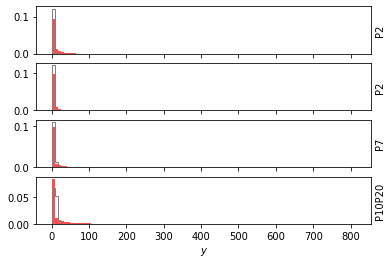

In [18]:
_ = Plotting.pred(prior_pred, obs=y, bins=100, xlabels=r'$y$', ylabels=group_names)

In [19]:
model.prior_checks(x, y)

OrderedDict([('pvalue',
              tensor([0.0000, 0.0680, 0.0000, 0.0000], device='cuda:0'))])

Stochastic variatonal inference

In [20]:
model.fit(x, y, num_iterations=2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Now we sample from the *posterior predictive* distribution. This will give us posterior samples for latent parameters, as well as posterior predictions for `obs'.

In [21]:
pred = model.posterior_predict(1000, x)

In [22]:
print(tabulate([[rv_name, rv_t.shape] for rv_name, rv_t in pred.items()]))

----  ---------------------------
mu    torch.Size([1000, 1])
s     torch.Size([1000, 1, 2])
w     torch.Size([1000, 4, 2])
b     torch.Size([1000, 4])
beta  torch.Size([1000, 4])
obs   torch.Size([1000, 1000, 4])
eta   torch.Size([1000, 1000, 4])
link  torch.Size([1000, 1000, 4])
----  ---------------------------


A simple predictive check is to verify that the observed data remains probable under the posterior predictive distribution. We can estimate the *posterior predictive p-value*
\begin{align}
    \Pr(Y > y|\mathcal D)
\end{align}
that is, the probability that a sample from the posterior predictive distribution is more extreme than the observation. 

Ideally, this *should not be close to extreme values*.

In [23]:
print(tabulate(
    zip(group_names, (pred['obs']  > y).float().mean((0,1))),
    headers=['system', 'predictive p-value']))

system      predictive p-value
--------  --------------------
P2                    0.411226
P2                    0.415285
P7                    0.426509
P10P20                0.424456


First, let's inspect whether our **posterior predictions** resemble the observed data.

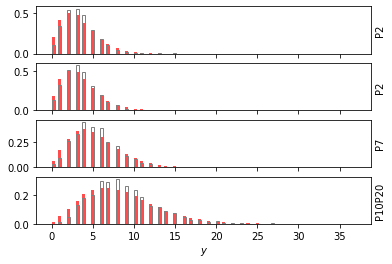

In [24]:
_ = Plotting.pred(pred, obs=y, bins=100, xlabels=r'$y$', ylabels=group_names)

Assuming they do, we are good to **interpret the latent parameters** below.

**Global offset**

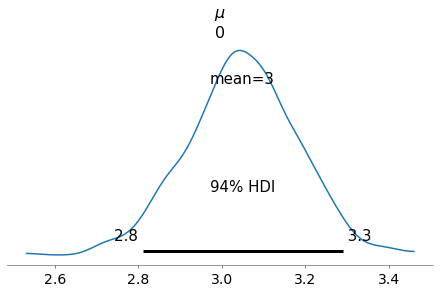

In [25]:
_ = Plotting.mu(pred)

**Feature-specific slopes**

* $s$ is feature specific
* $w$ is group-specific and feature-specific

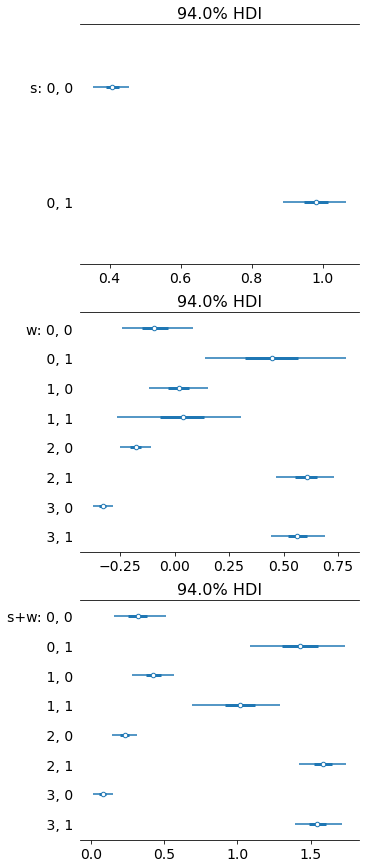

In [26]:
_ = Plotting.slope(pred, figsize=(5, 15))

**Offset**

* $\mu$ is global
* $b$ is group specific

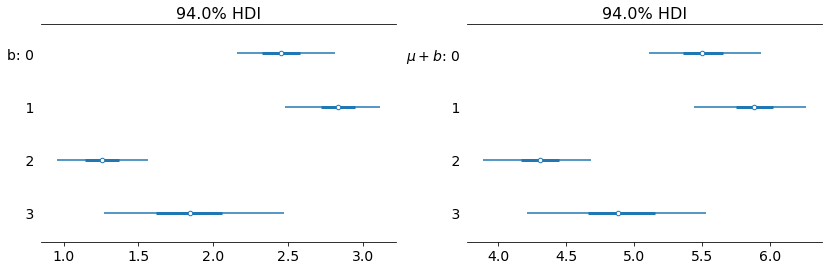

In [27]:
_ = Plotting.bias(pred, figsize=(14,4))

# Other Latent Quantities

It's useful to appreciate properties of the posterior parameters of the sampling distribution

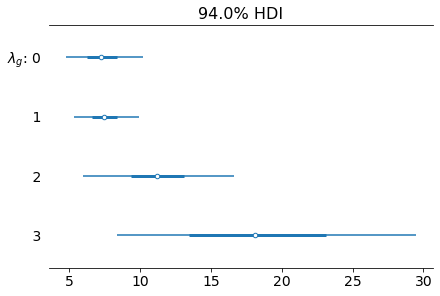

In [28]:
_ = arviz.plot_forest({r'$\lambda_g$': (pred['link']).reshape(1, -1, y.shape[-1]).cpu().numpy()}, figsize=(6, 4))

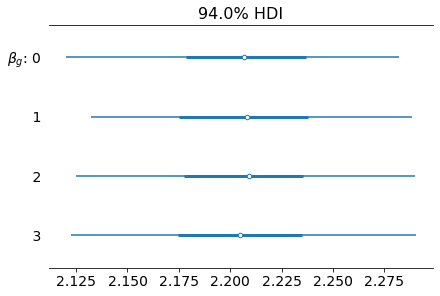

In [29]:
if 'beta' in pred:
    _ = arviz.plot_forest({r'$\beta_g$': pred['beta'].unsqueeze(0).cpu().numpy()}, figsize=(6, 4))

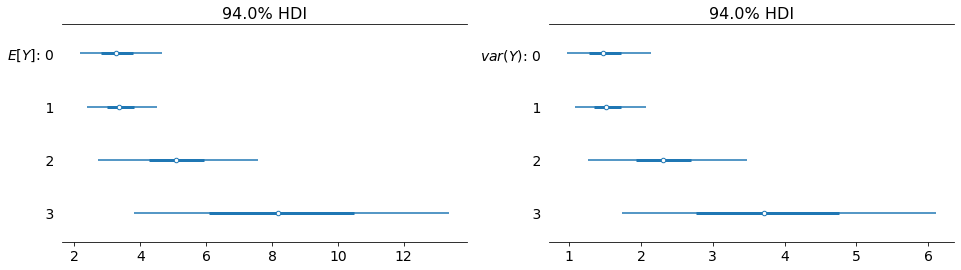

In [30]:
if 'beta' in pred:
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 4))  
    _ = arviz.plot_forest({r'$E[Y]$': (pred['link']/pred['beta'].unsqueeze(1)).reshape(1, -1, y.shape[-1]).cpu().numpy()}, ax=ax[0])
    _ = arviz.plot_forest({r'$var(Y)$': (pred['link']/(pred['beta']**2).unsqueeze(1)).reshape(1, -1, y.shape[-1]).cpu().numpy()}, ax=ax[1])